In [3]:
%%capture
# Library Installation
!pip install gensim
# EDA SOURCE - https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#3.-Target-and-N-grams

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS
import string
from collections import defaultdict
from wordcloud import WordCloud
import gensim.downloader as api
import re
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
%matplotlib inline
plt.style.use('bmh')

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

# Data - https://www.kaggle.com/competitions/nlp-getting-started/overview

Mounted at /content/drive


In [5]:
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
train_data = pd.read_csv("./drive/MyDrive/Tweets/train.csv")
test_data = pd.read_csv("./drive/MyDrive/Tweets/test.csv")

In [7]:
train_data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### **EDA**

In [9]:
null_counts = train_data.isnull().sum()

null_counts[null_counts > 0].sort_values(ascending=False)

location    2533
keyword       61
dtype: int64

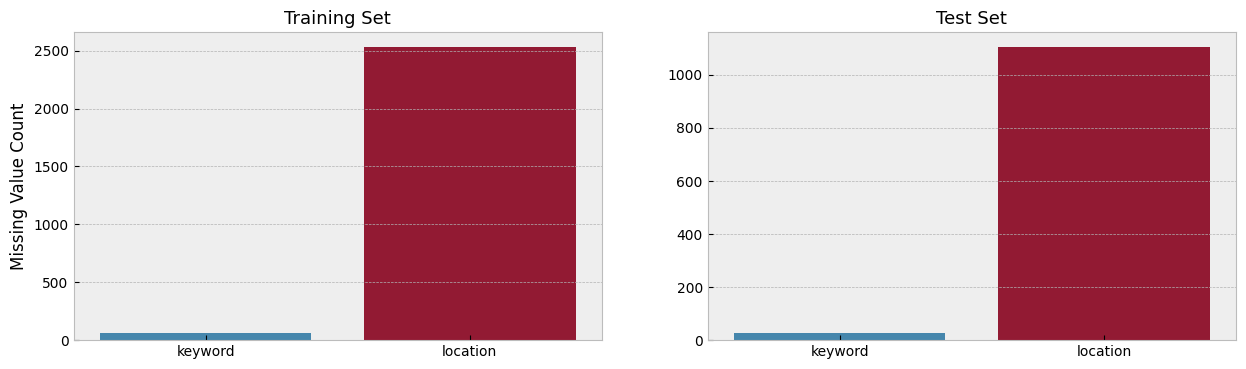

In [10]:
cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(15, 4), dpi=100)

sns.barplot(x = train_data[cols].isnull().sum().index, y = train_data[cols].isnull().sum().values, hue=cols, legend=False, ax=axes[0])
sns.barplot(x = test_data[cols].isnull().sum().index, y = test_data[cols].isnull().sum().values, hue=cols, legend=False, ax=axes[1])
axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)
axes[0].set_ylabel('Missing Value Count')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.show()

In [11]:
# Filling these missing data with custom text
for df in [train_data, test_data]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [12]:
# unique values
print(f"Unique values in 'keyword' for Train Data is {train_data['keyword'].nunique()} and for Test Data is {test_data['keyword'].nunique()} ")
print(f"Unique values in 'location' for Train Data is {train_data['location'].nunique()} and for Test Data is {test_data['location'].nunique()} ")

Unique values in 'keyword' for Train Data is 222 and for Test Data is 222 
Unique values in 'location' for Train Data is 3342 and for Test Data is 1603 


In [13]:
train_data.groupby('keyword')['target'].count().sort_values(ascending=False)

keyword
no_keyword               61
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 222, dtype: int64

In [14]:
# Creating new features from the text data such as word count and all
def create_features(df):
  df['text'].astype('str')

  df['word_count'] = df['text'].apply(lambda x : len(x.split()))

  df['unique_word_count'] = df['text'].apply(lambda x : len(set(x.split())))

  df['stop_word_count'] = df['text'].apply(lambda x : len([w for w in x.lower().split() if w in STOPWORDS]))

  df['url_count'] = df['text'].apply(lambda x : len([w for w in x.lower().split() if 'http' in w or 'https' in w]))

  df['char_count'] = df['text'].apply(lambda x : len(x))

  df['punctuation_count'] = df['text'].apply(lambda x : len([c for c in x if c in string.punctuation]))

  df['hashtag_count'] = df['text'].apply(lambda x : len([c for c in x if c == '#']))

  df['mention_count'] = df['text'].apply(lambda x : len([c for c in x if c == '@']))

  return df

In [15]:
train_data = create_features(train_data)
test_data = create_features(test_data)

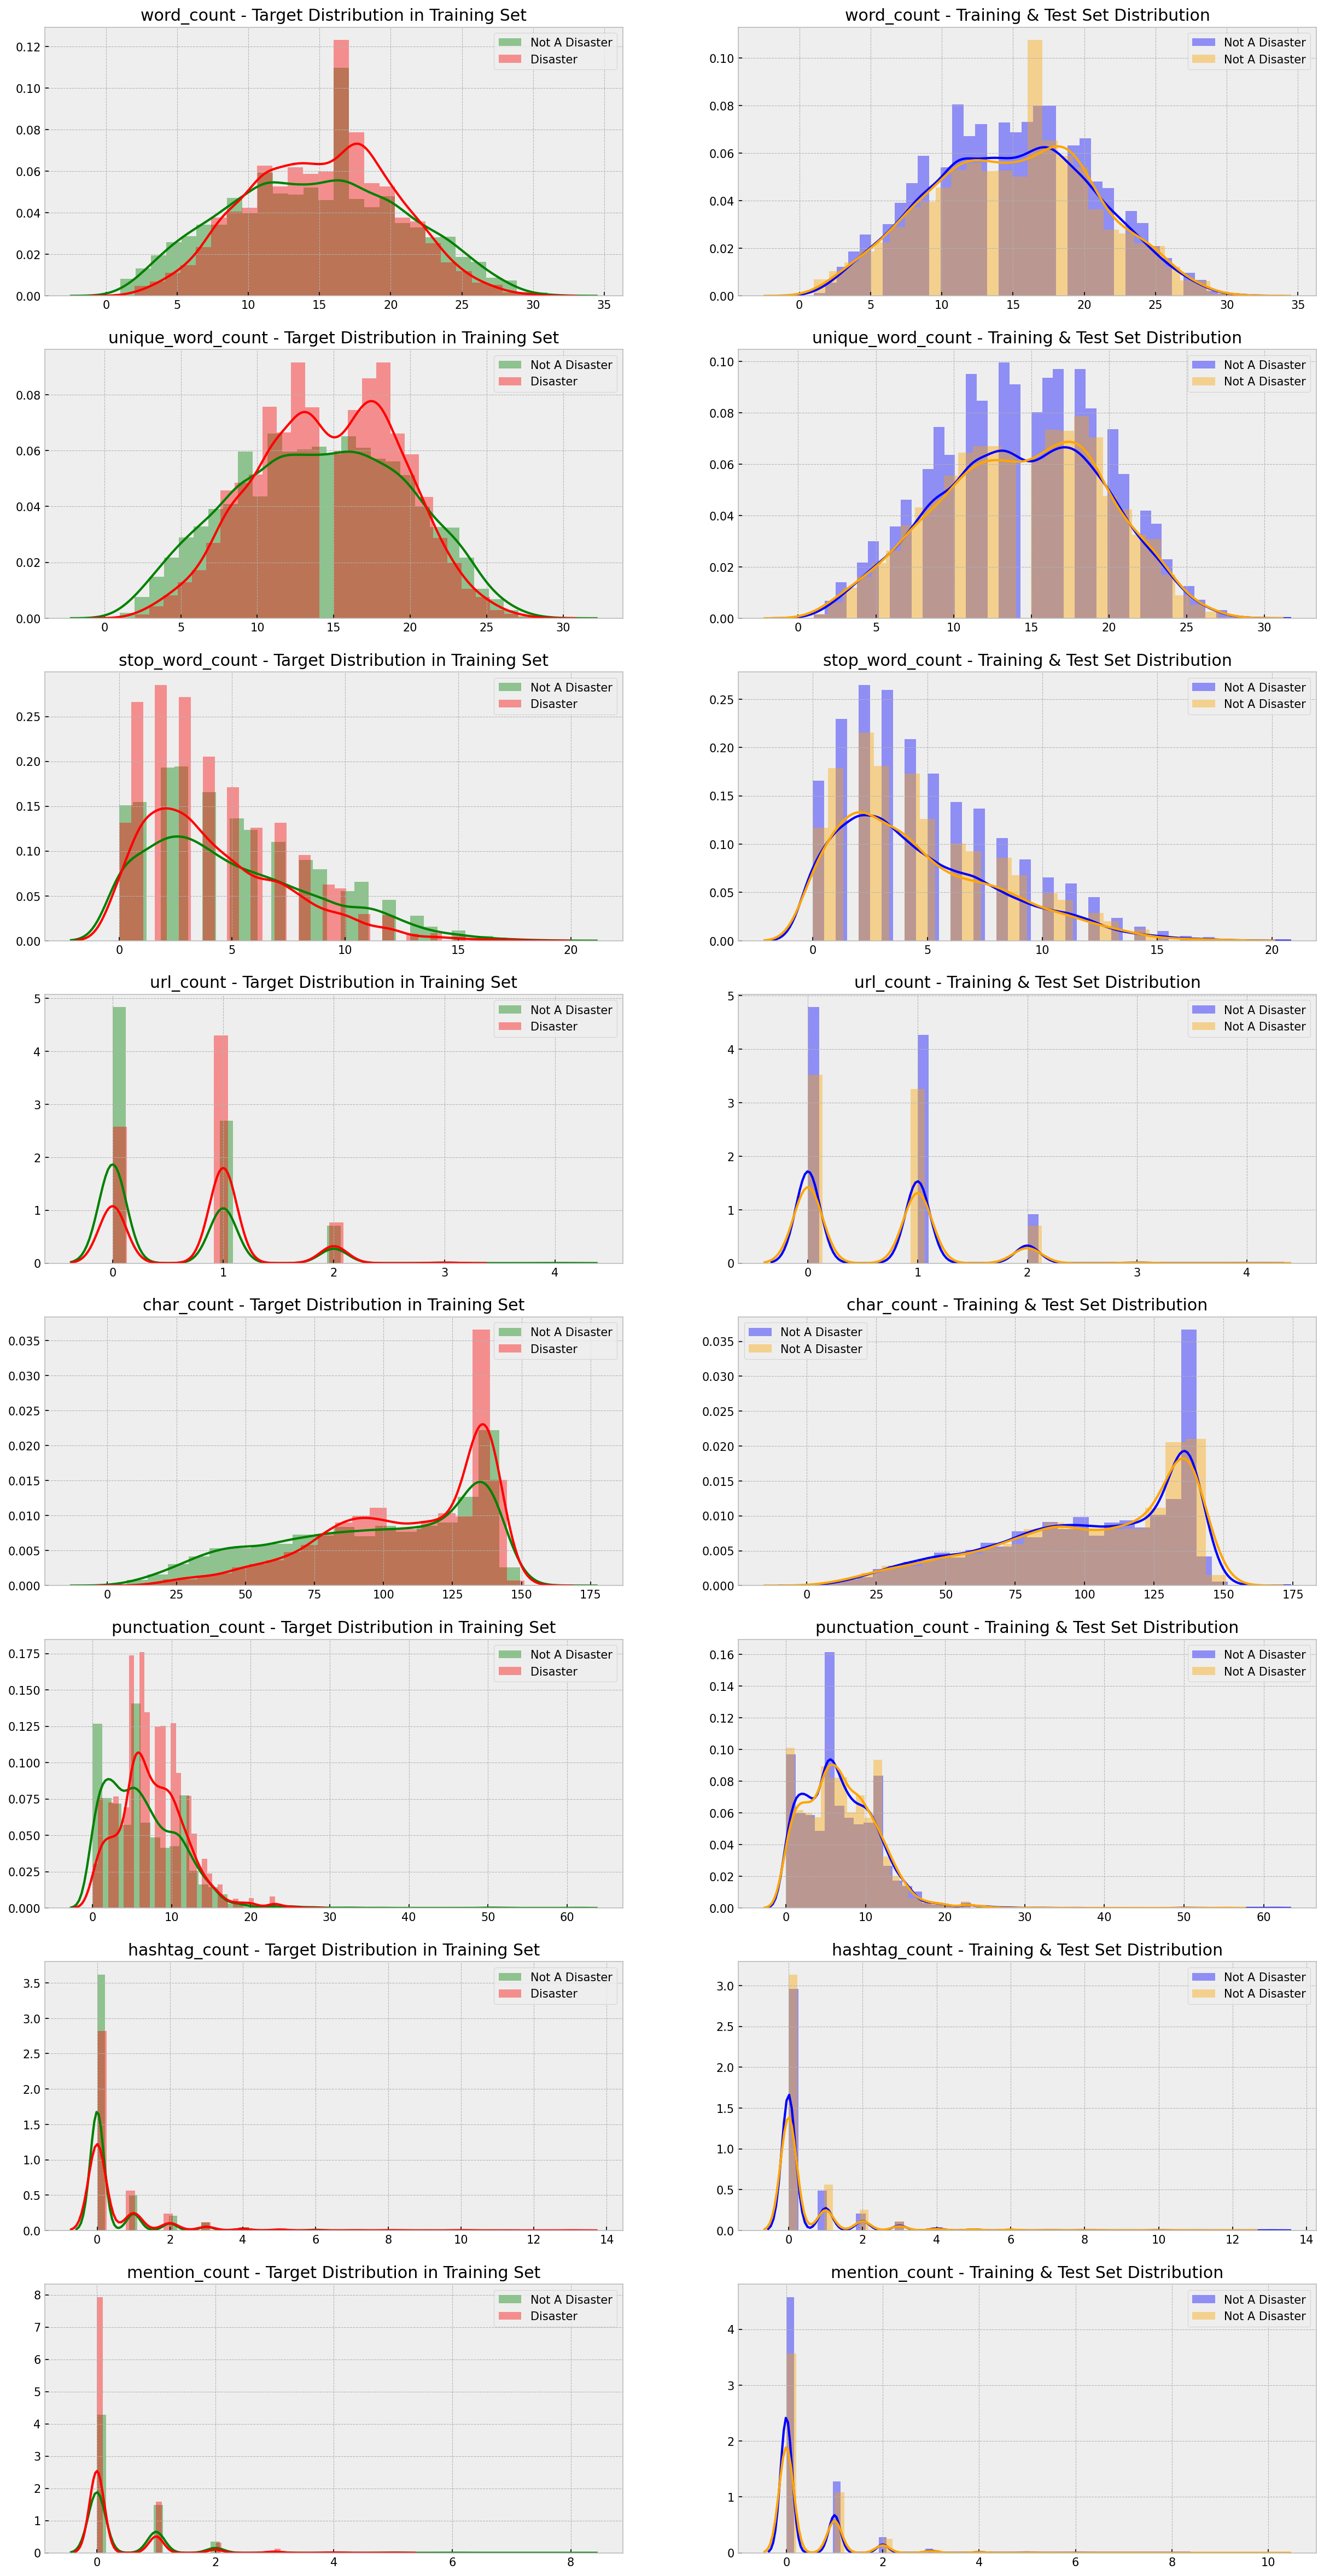

In [16]:
# Plot the distribution of all the features
DISASTER_TWEETS = train_data['target'] == 1
added_feature = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

fig, axes = plt.subplots(ncols = 2, nrows = len(added_feature), figsize=(20, 40), dpi=150)

for i, feat in enumerate(added_feature):
  sns.distplot(train_data.loc[~DISASTER_TWEETS][feat], ax = axes[i][0], color = 'green', label = "Not A Disaster")
  sns.distplot(train_data.loc[DISASTER_TWEETS][feat], ax = axes[i][0], color = 'red', label = "Disaster")

  sns.distplot(train_data[feat], ax = axes[i][1], color = 'blue', label = "Not A Disaster")
  sns.distplot(test_data[feat], ax = axes[i][1], color = 'orange', label = "Not A Disaster")

  for j in range(2):
    axes[i][j].set_xlabel('')
    axes[i][j].set_ylabel('')
    axes[i][j].tick_params(axis='x')
    axes[i][j].tick_params(axis='y')
    axes[i][j].legend()

  axes[i][0].set_title(f'{feat} - Target Distribution in Training Set')
  axes[i][1].set_title(f'{feat} - Training & Test Set Distribution')

plt.show()

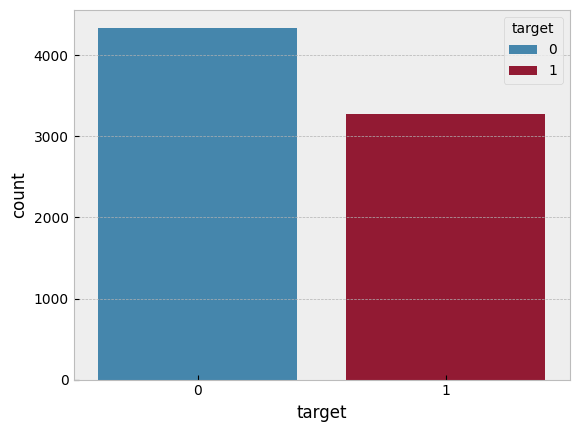

In [17]:
sns.countplot(x=train_data['target'], hue=train_data['target'])
plt.show()

In [18]:
full_text = " ".join(text for text in train_data.text)
print ("There are {} characters in the combination of all text.".format(len(full_text)))

There are 776810 characters in the combination of all text.


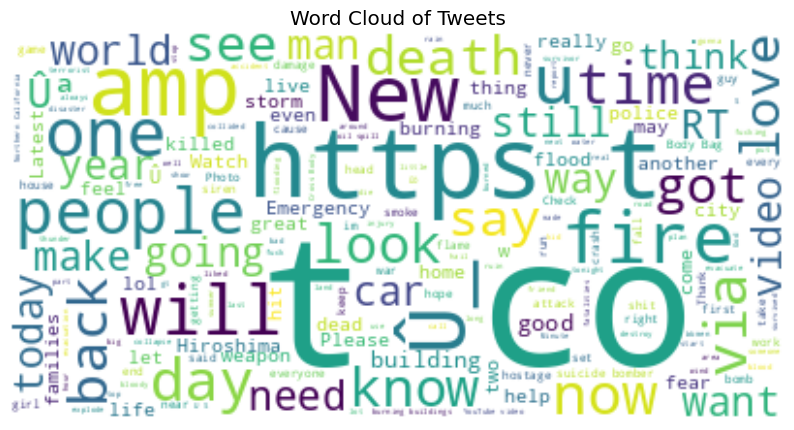

In [19]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(full_text)

plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Tweets')
plt.show()

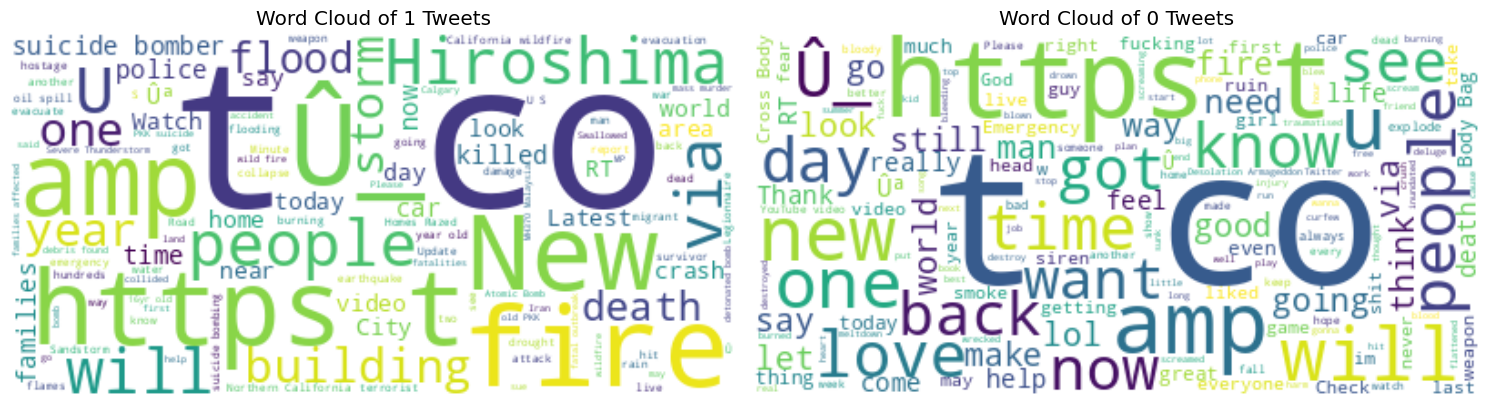

In [20]:
# visualizing word cloud specific to the class label
fig, axes = plt.subplots(ncols=2, figsize=(15, 4), dpi=100)

target_labels = train_data['target'].unique()
for i, target in enumerate(target_labels):

  full_text = " ".join(text for text in train_data.loc[train_data['target'] == target].text)
  wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(full_text)
  ax = axes[i]
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(f'Word Cloud of {target} Tweets')

plt.tight_layout()
plt.show()

In [21]:
def get_ngrams(text, n_grams):
  tokens = []
  for token in text.lower().split(' '):
    if token != '' and token not in STOPWORDS:
      tokens.append(token)

  ngram_data = []
  for t in range(len(tokens) - n_grams + 1):
    ngram_data.append(tokens[t:t+n_grams])

  return [" ".join(n) for n in ngram_data]

In [22]:
def get_ngram_df(data, n):
  disaster_ngrams = {}
  nondisaster_ngrams = {}

  for tweet in data[DISASTER_TWEETS]['text']:
      for word in get_ngrams(tweet, n):
          disaster_ngrams[word] = disaster_ngrams.get(word, 0) + 1

  for tweet in data[~DISASTER_TWEETS]['text']:
      for word in get_ngrams(tweet, n):
          nondisaster_ngrams[word] = nondisaster_ngrams.get(word, 0) + 1

  df_disaster_ngrams = pd.DataFrame(sorted(disaster_ngrams.items(), key=lambda x: x[1], reverse=True), columns=['n-gram', 'count'])
  df_nondisaster_ngrams = pd.DataFrame(sorted(nondisaster_ngrams.items(), key=lambda x: x[1], reverse=True), columns=['n-gram', 'count'])

  return (df_disaster_ngrams, df_nondisaster_ngrams)

In [23]:
dis_uni, nondis_uni = get_ngram_df(train_data, 1)
dis_bi, nondis_bi = get_ngram_df(train_data, 2)
dis_tri, nondis_tri = get_ngram_df(train_data, 3)

In [24]:
def plot_ngrams(dis, nondis, top = 20):
  fig, axes = plt.subplots(ncols = 2, figsize = (20, 10), dpi = 150)

  sns.barplot(y=dis['n-gram'].values[:top], x=dis['count'].values[:top], ax=axes[0], color='red')
  sns.barplot(y=nondis['n-gram'].values[:top], x=nondis['count'].values[:top], ax=axes[1], color='green')

  for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

  axes[0].set_title(f'Top {top} most common unigrams in Disaster Tweets')
  axes[1].set_title(f'Top {top} most common unigrams in Non-disaster Tweets')

  plt.tight_layout()
  plt.show()

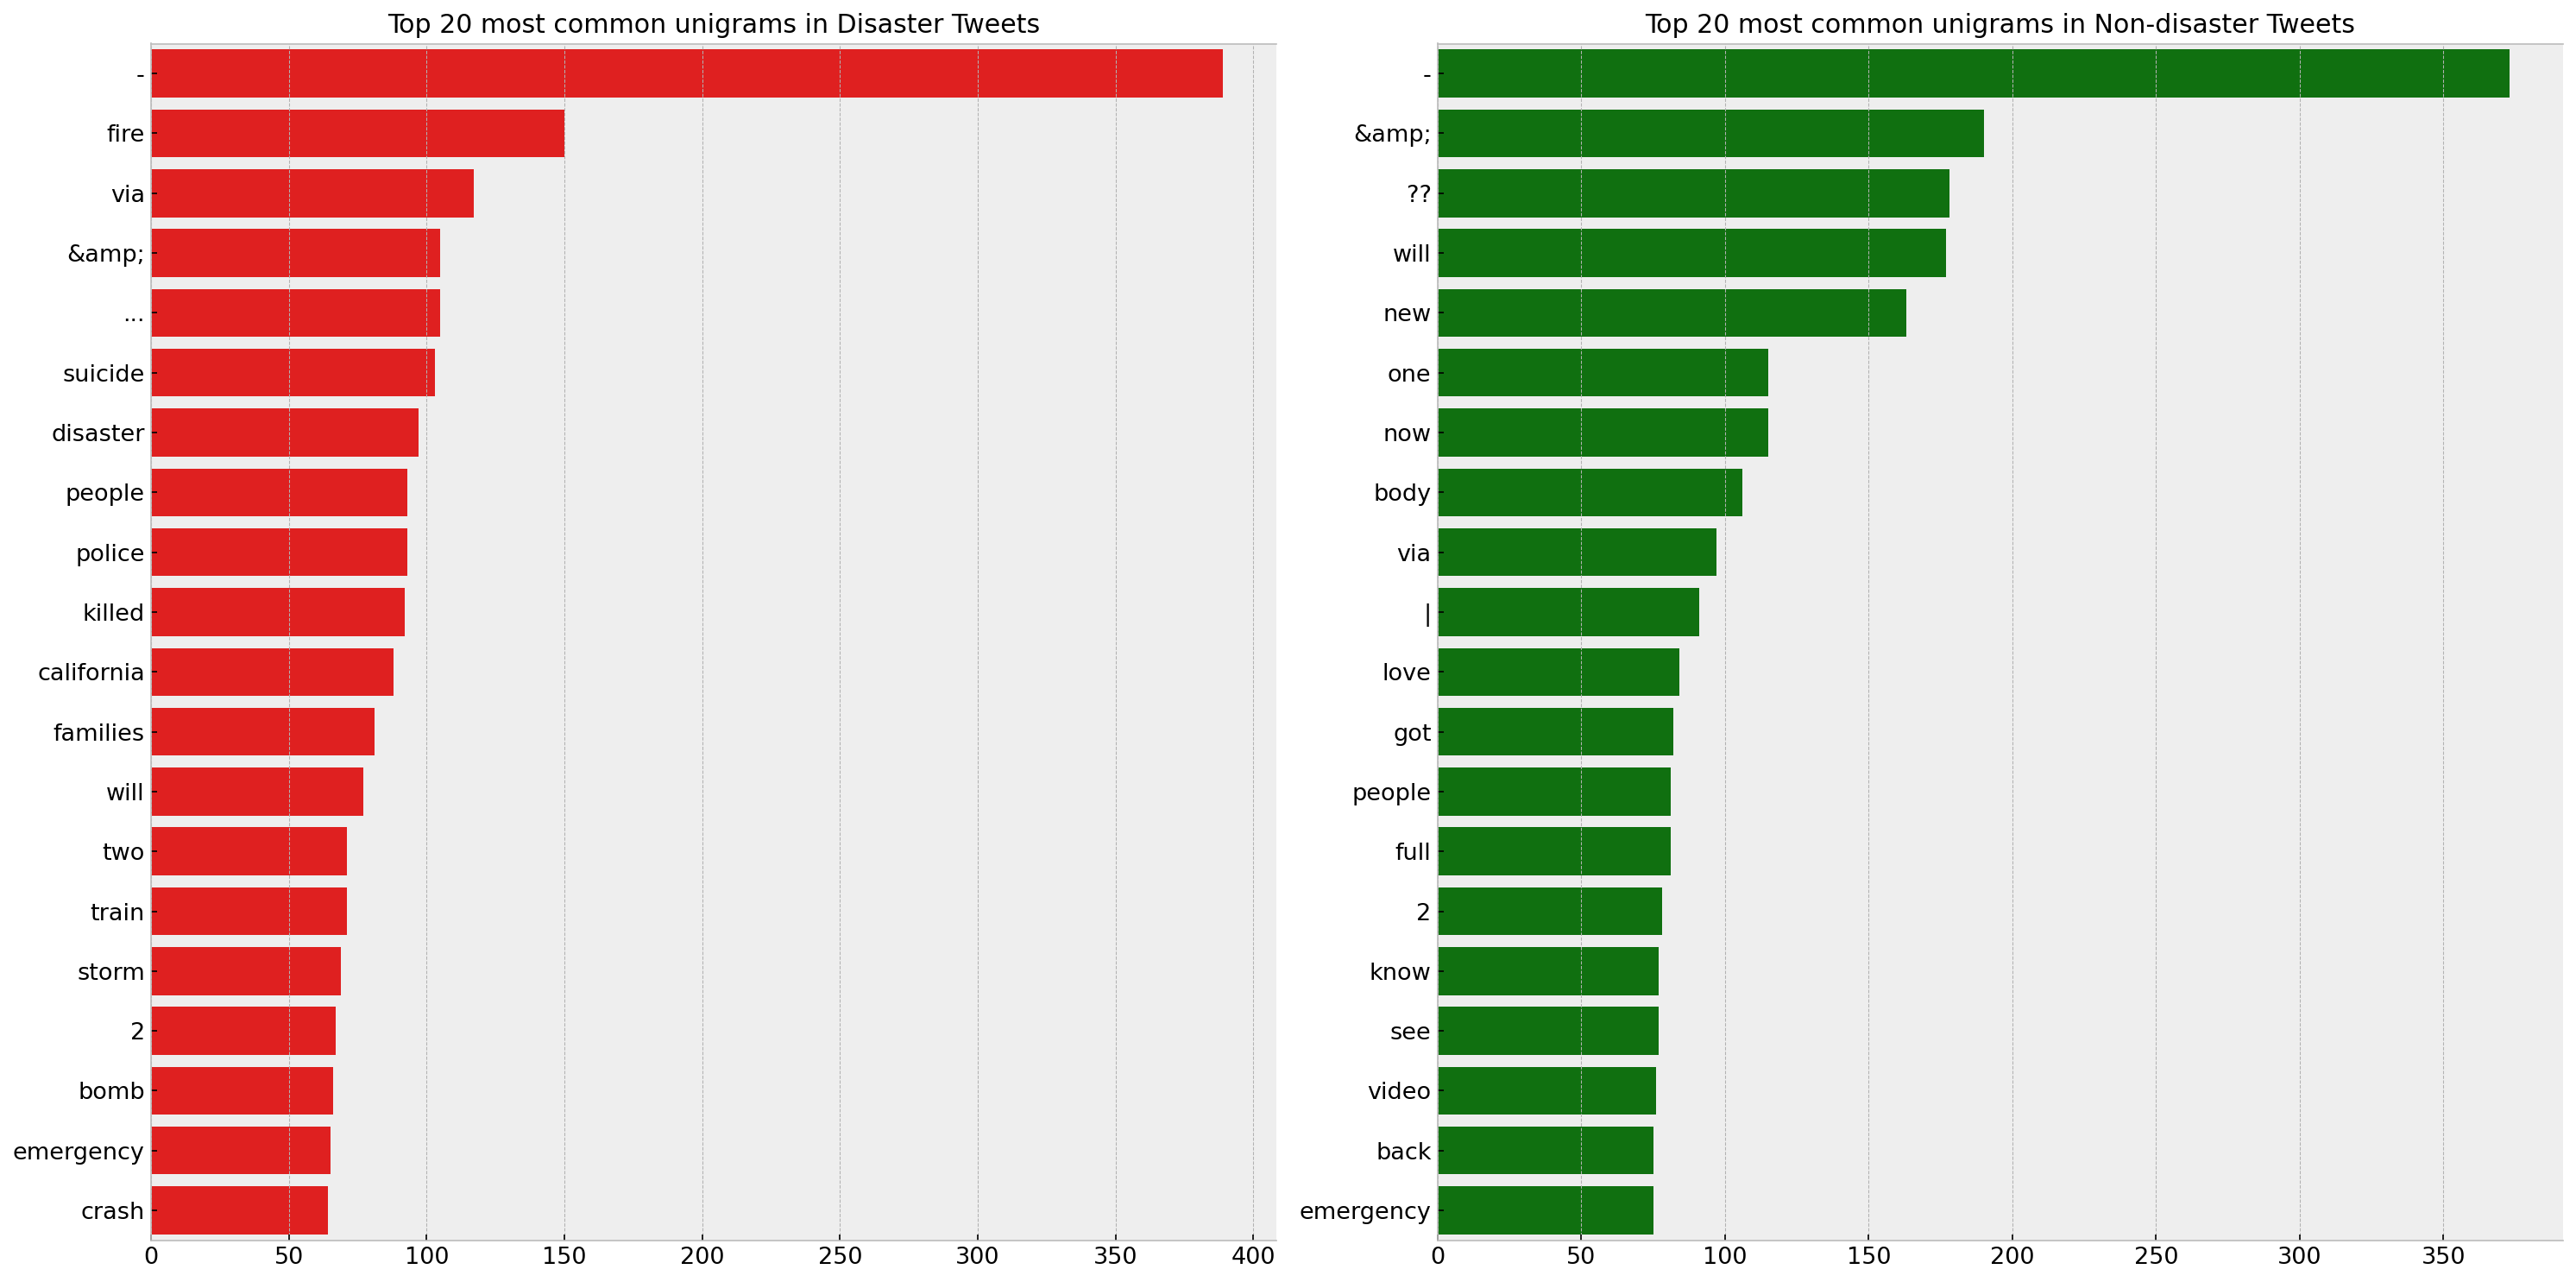

In [25]:
plot_ngrams(dis_uni, nondis_uni)

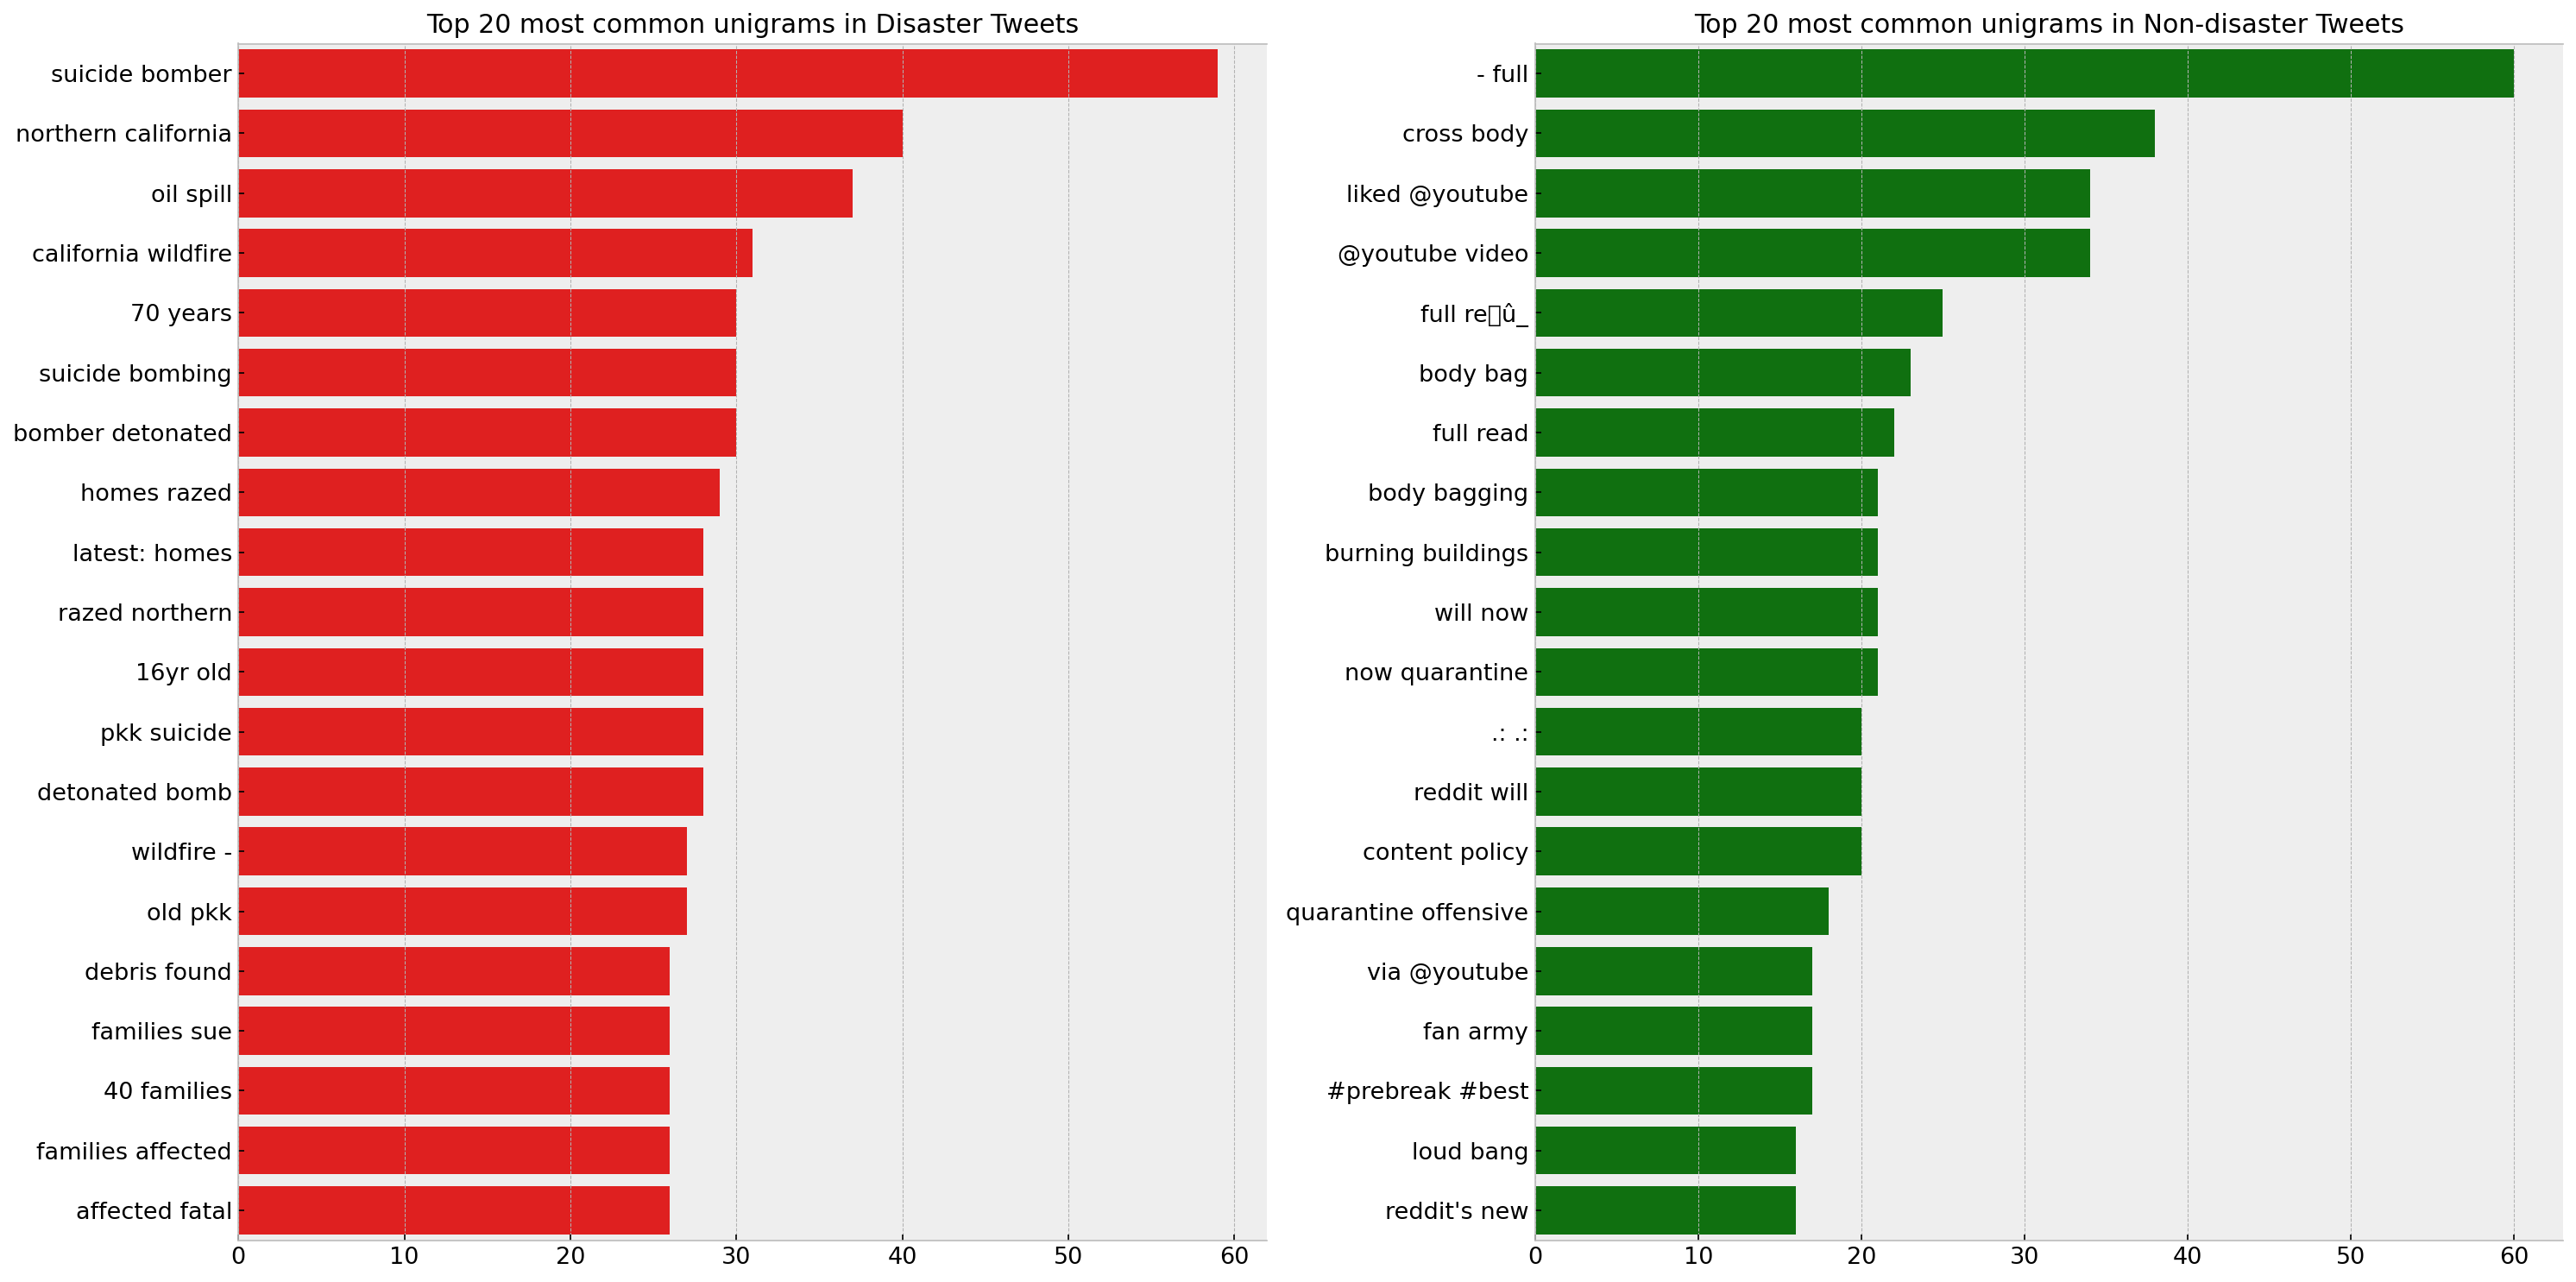

In [26]:
plot_ngrams(dis_bi, nondis_bi)

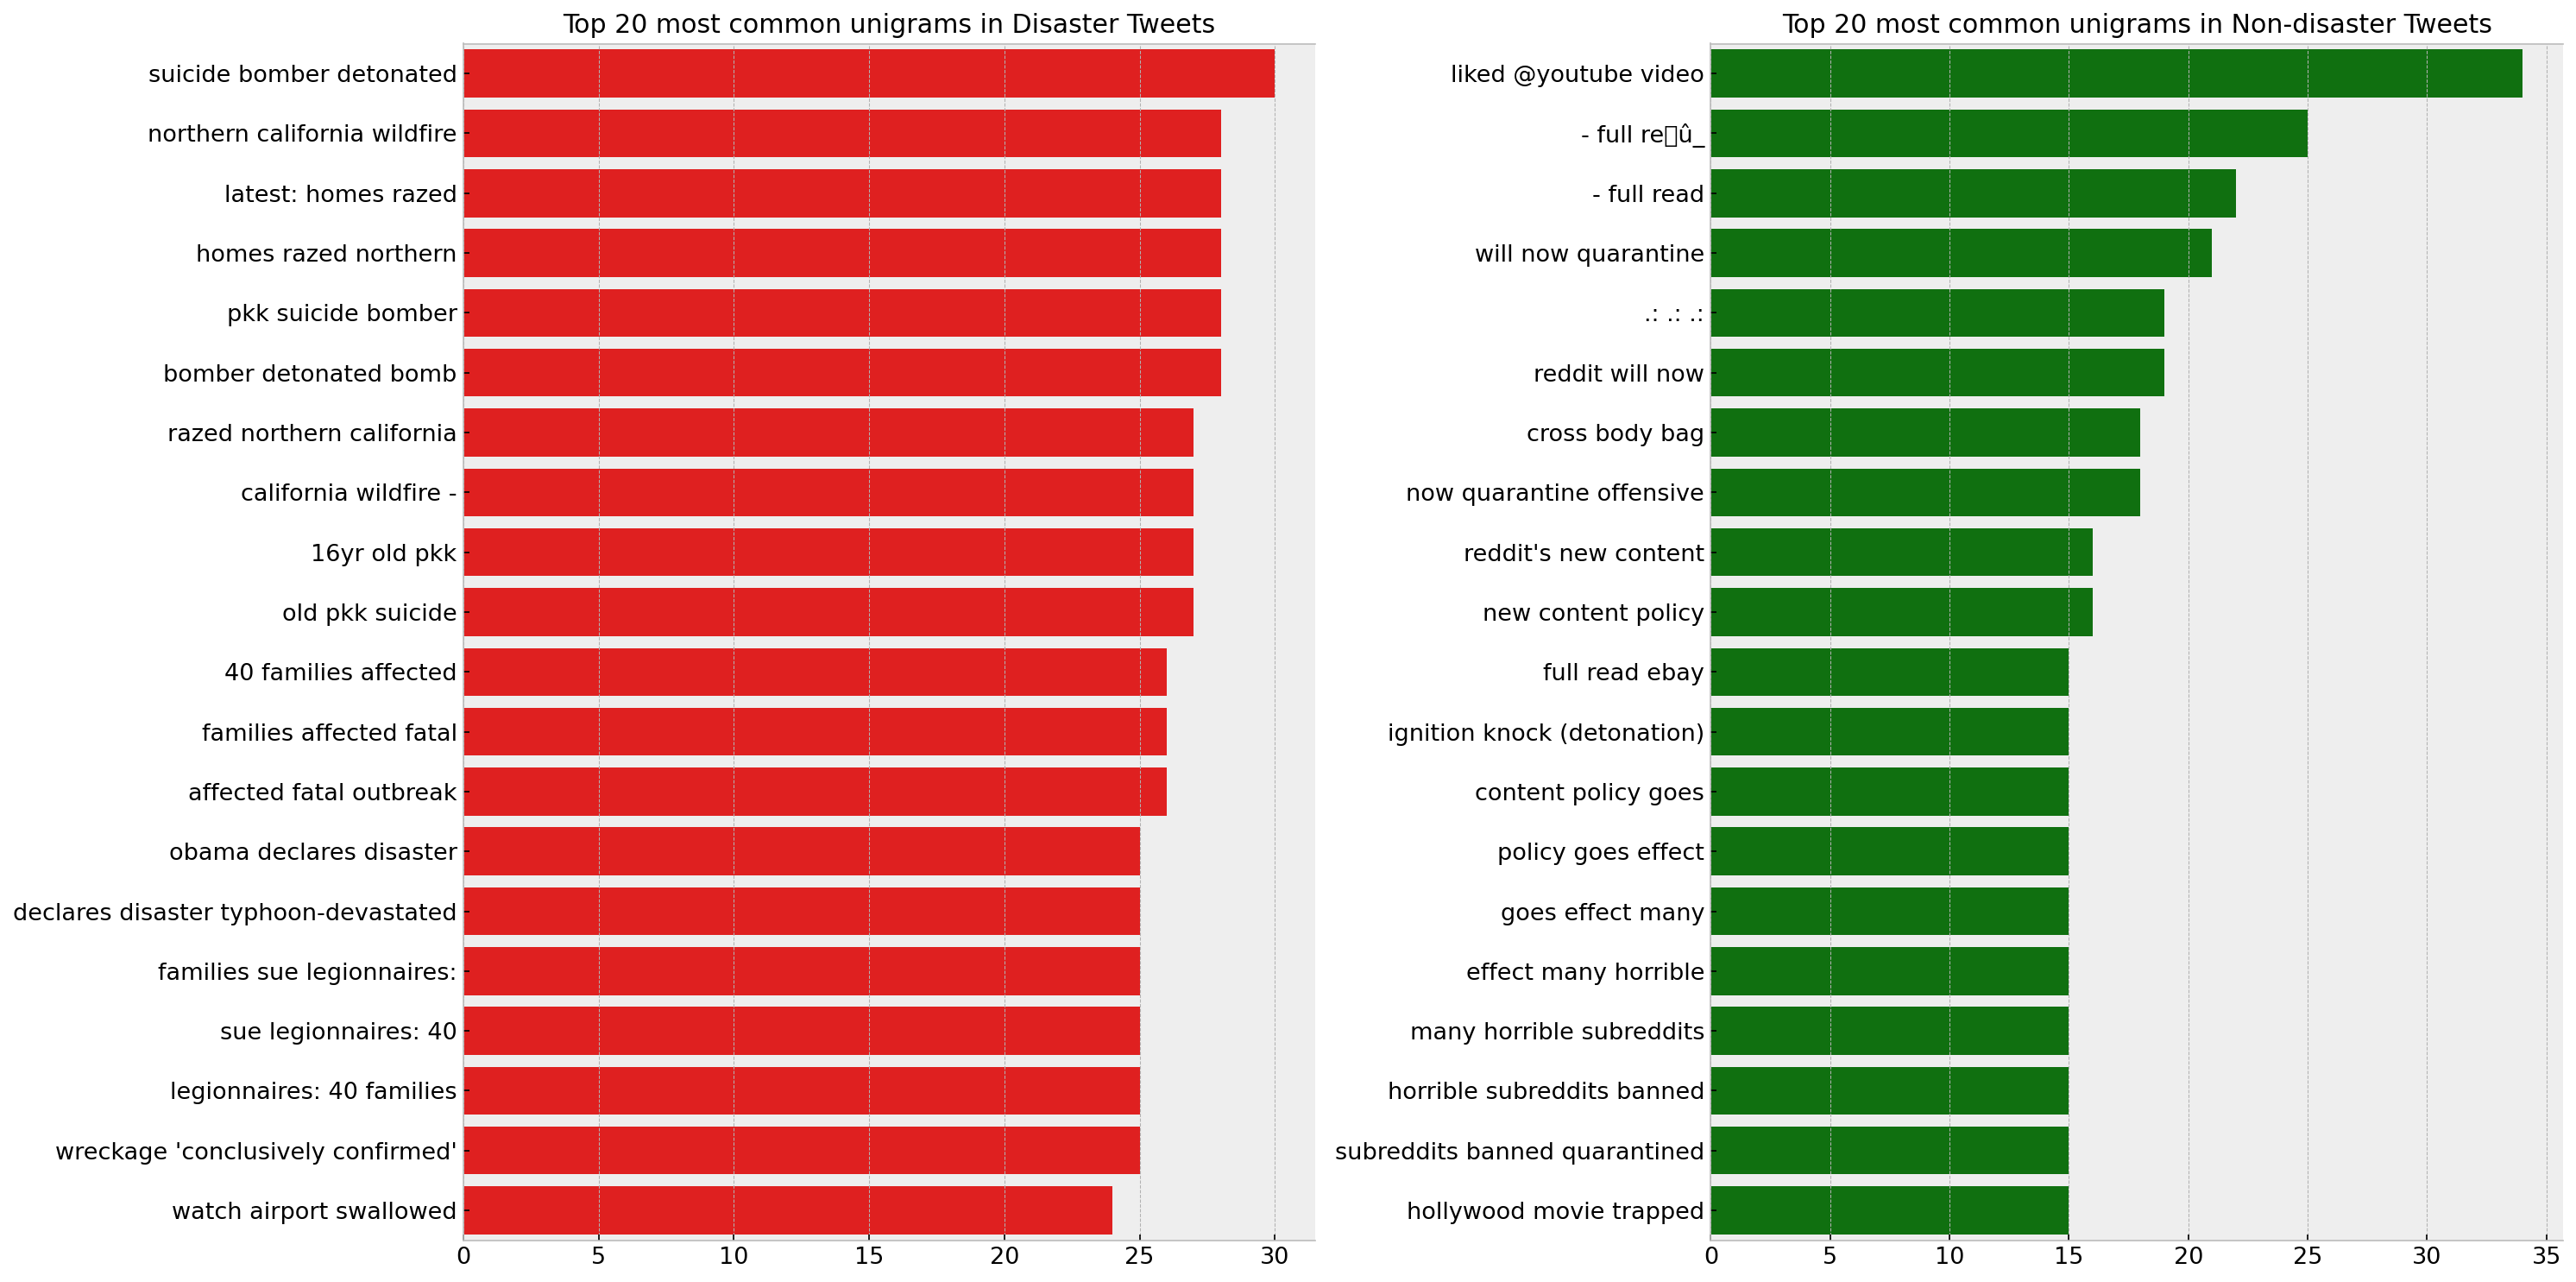

In [27]:
plot_ngrams(dis_tri, nondis_tri)

### **Text Preprocessing**

In [28]:
glove_vectors = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [29]:
def get_vocab(txt):
  all_txts = txt.apply(lambda sent : sent.split()).values

  vocab = {}
  for text in all_txts:
    for ele in text:
      vocab[ele] = vocab.get(ele, 1) + 1

  return vocab

In [30]:
def chk_embeddings(txt, emb):

  vocab = get_vocab(txt)

  present = {}
  not_present = {}
  freq_pres = 0
  freq_not = 0

  for word, cnt in vocab.items():
    if word in emb:
      present[word] = emb[word]
      freq_pres += cnt
    else:
      not_present[word] = cnt
      freq_not += cnt

  vocab_coverage = len(present) / len(vocab)
  text_coverage = (freq_pres / (freq_pres + freq_not))

  return not_present, vocab_coverage, text_coverage

In [31]:
vocab_not, vocab_chk, text_chk = chk_embeddings(train_data['text'], glove_vectors)
vocab_not_test, vocab_chk_test, text_chk_test = chk_embeddings(test_data['text'], glove_vectors)

print(f"Training Dataset: Glove embedding results for vocabulary is {vocab_chk:.2%} and text is {text_chk:.2%}.")
print(f"Testing Dataset: Glove embedding results for vocabulary is {vocab_chk_test:.2%} and text is {text_chk_test:.2%}.")

Training Dataset: Glove embedding results for vocabulary is 23.64% and text is 49.44%.
Testing Dataset: Glove embedding results for vocabulary is 27.22% and text is 48.24%.


In [32]:
nlp = spacy.load("en_core_web_md")

def pre_process(txt):
  docs = nlp(txt.lower())
  processed_tokens = [token.lemma_ for token in docs]
  processed_text = " ".join(processed_tokens)

  return processed_text

In [33]:
train_data['text'] = train_data['text'].apply(pre_process)

In [34]:
test_data['text'] = test_data['text'].apply(pre_process)

In [35]:
vocab_not, vocab_chk, text_chk = chk_embeddings(train_data['text'], glove_vectors)
vocab_not_test, vocab_chk_test, text_chk_test = chk_embeddings(test_data['text'], glove_vectors)

print(f"Training Dataset: Glove embedding results for vocabulary is {vocab_chk:.2%} and text is {text_chk:.2%}.")
print(f"Testing Dataset: Glove embedding results for vocabulary is {vocab_chk_test:.2%} and text is {text_chk_test:.2%}.")

Training Dataset: Glove embedding results for vocabulary is 50.14% and text is 84.12%.
Testing Dataset: Glove embedding results for vocabulary is 58.19% and text is 84.01%.


In [36]:
import json
vocab_not_order = sorted(vocab_not.items(), key=lambda x:x[1], reverse=True)

print(vocab_not_order)

[('I', 2103), ('..', 121), ('@youtube', 84), ('mh370', 72), ('\x89û', 59), ('\x89ûò', 40), ('prebreak', 31), ('16yr', 29), ('re\x89û', 28), ('\x89ûó', 27), ('w/', 27), ('):', 25), ('bestnaijamade', 25), ('gbbo', 21), ('disea', 20), ('traumatise', 18), ('funtenna', 18), ('subreddit', 18), ('lmao', 17), ('nowplaye', 16), ('don\x89ûªt', 16), ('m.o.p', 15), ('time2015', 15), ('utc2015', 15), ('//', 13), ('\x89ûïwhen', 13), ('nowplaying', 12), ('gt;&gt', 12), ('/r', 12), ('@arianagrande', 12), ('worldnew', 11), ('©', 11), ('sismo', 11), ('yyc', 11), ('......', 10), ('@potus', 10), ('@change', 10), ('directioner', 10), ('spos', 10), ('@usatoday', 10), ('@foxnew', 10), ('irandeal', 10), ('trfc', 10), ('http://t.co/qew4c5m1xd', 10), ('abstorm', 10), ('beyhive', 9), ('rea\x89û', 9), ('o784', 9), ('selfie', 9), ('it\x89ûªs', 9), ('@emmerdale', 9), ('hwo', 9), ('mediterran', 9), ('icemoon', 8), ('@djicemoon', 8), ('trapmusic', 8), ('ices\x89û', 8), ('tcot', 8), ('lt;3', 8), ('mhtw4fnet', 8), ('rì

In [37]:
%%time
# we can do more preprocessing

def clean_txt(txt):

  # Special characters
  txt = re.sub(r"I", "I",txt)
  txt = re.sub(r'@\w+', '', txt)
  txt = re.sub(r'#\w+', '', txt)
  txt = re.sub(r'http\S+', '', txt)
  txt = re.sub(r'[^a-zA-Z\s]', '', txt)

  txt = re.sub(r"&gt;", ">", txt)
  txt = re.sub(r"&lt;", "<", txt)
  txt = re.sub(r"&amp;", "&", txt)

  punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
  for p in punctuations:
      txt = txt.replace(p, f' {p} ')

  txt = txt.replace('...', ' ... ')
  if '...' not in txt:
      txt = txt.replace('..', ' ... ')

  return txt

train_data['text'] = train_data['text'].apply(clean_txt)
test_data['text'] = test_data['text'].apply(clean_txt)

CPU times: user 207 ms, sys: 3.06 ms, total: 210 ms
Wall time: 213 ms


In [38]:
vocab_not, vocab_chk, text_chk = chk_embeddings(train_data['text'], glove_vectors)
vocab_not_test, vocab_chk_test, text_chk_test = chk_embeddings(test_data['text'], glove_vectors)

print(f"Training Dataset: Glove embedding results for vocabulary is {vocab_chk:.2%} and text is {text_chk:.2%}.")
print(f"Testing Dataset: Glove embedding results for vocabulary is {vocab_chk_test:.2%} and text is {text_chk_test:.2%}.")

Training Dataset: Glove embedding results for vocabulary is 81.52% and text is 93.73%.
Testing Dataset: Glove embedding results for vocabulary is 85.09% and text is 93.70%.


In [39]:
# There is text data which has been mislabeled!
duplicate_text = train_data[train_data.duplicated(['text'], keep=False)]

In [40]:
duplicate_text = duplicate_text[['text', 'target']]
mislabled_data = duplicate_text.groupby('text').filter(lambda x: x['target'].nunique() > 1)

In [41]:
mislabeled_idx = mislabled_data.index
train_data.drop(mislabeled_idx, inplace=True)

In [42]:
train_data['target'].value_counts()

target
0    4190
1    3168
Name: count, dtype: int64

In [43]:
kfold = KFold(n_splits=3)

for i, (train_index, test_index) in enumerate(kfold.split(train_data['text'], train_data['target'])):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, length={len(train_index)}")
    print(f"  Test:  index={test_index}, length={len(test_index)}")

Fold 0:
  Train: index=[2453 2454 2455 ... 7355 7356 7357], length=4905
  Test:  index=[   0    1    2 ... 2450 2451 2452], length=2453
Fold 1:
  Train: index=[   0    1    2 ... 7355 7356 7357], length=4905
  Test:  index=[2453 2454 2455 ... 4903 4904 4905], length=2453
Fold 2:
  Train: index=[   0    1    2 ... 4903 4904 4905], length=4906
  Test:  index=[4906 4907 4908 ... 7355 7356 7357], length=2452


### **Modelling**

In [44]:
# getting all the metrics such as precision, recall, f score and accuracy
class TraditionalClassification:
  def __init__(self, model, kf):
    self.model = model
    self.kf = kf
    self.evaluation_scores = {"train_accuracy" : [],
                                  "train_precision" : [],
                                  "train_recall" : [],
                                  "train_f1" : [],
                                  "val_accuracy" : [],
                                  "val_precision" : [],
                                  "val_recall" : [],
                                  "val_f1" : [],}

  def fit_and_eval(self, X, y):
    for fld, (train_idx, val_idx) in enumerate(self.kf.split(X)):
      X_train, X_val = X[train_idx], X[val_idx]
      y_train, y_val = y[train_idx], y[val_idx]
      print(y_train.shape)

      self.model.fit(X_train, y_train)

      train_pred = self.model.predict(X_train)
      train_acc = accuracy_score(y_train, train_pred)
      train_precision = precision_score(y_train, train_pred, average="macro")
      train_recall = recall_score(y_train, train_pred, average="macro")
      train_f1 = f1_score(y_train, train_pred, average="macro")
      self.evaluation_scores["train_accuracy"].append(train_acc)
      self.evaluation_scores["train_precision"].append(train_acc)
      self.evaluation_scores["train_recall"].append(train_acc)
      self.evaluation_scores["train_f1"].append(train_acc)

      val_pred = self.model.predict(X_val)
      val_acc = accuracy_score(y_val, val_pred)
      val_precision = precision_score(y_val, val_pred, average="macro")
      val_recall = recall_score(y_val, val_pred, average="macro")
      val_f1 = f1_score(y_val, val_pred, average="macro")
      self.evaluation_scores["val_accuracy"].append(val_acc)
      self.evaluation_scores["val_precision"].append(val_precision)
      self.evaluation_scores["val_recall"].append(val_recall)
      self.evaluation_scores["val_f1"].append(val_f1)

      print(f'\nFold {fld+1} - Training Accuracy: {self.evaluation_scores["train_accuracy"][-1]:.6f} - '
                  f'Training Precision: {self.evaluation_scores["train_precision"][-1]:.6f} - '
                  f'Training Recall: {self.evaluation_scores["train_recall"][-1]:.6f} - '
                  f'Training F1: {self.evaluation_scores["train_f1"][-1]:.6f}')
      print(f'Fold {fld+1} - Validation Accuracy: {self.evaluation_scores["val_accuracy"][-1]:.6f} - '
                  f'Validation Precision: {self.evaluation_scores["val_precision"][-1]:.6f} - '
                  f'Validation Recall: {self.evaluation_scores["val_recall"][-1]:.6f} - '
                  f'Validation F1: {self.evaluation_scores["val_f1"][-1]:.6f}')

    print(f'\nAverage Training Accuracy: {np.mean(self.evaluation_scores["train_accuracy"]):.6f}')
    print(f'Average Training Precision: {np.mean(self.evaluation_scores["train_precision"]):.6f}')
    print(f'Average Training Recall: {np.mean(self.evaluation_scores["train_recall"]):.6f}')
    print(f'Average Training F1: {np.mean(self.evaluation_scores["train_f1"]):.6f}')
    print(f'Average Validation Accuracy: {np.mean(self.evaluation_scores["val_accuracy"]):.6f}')
    print(f'Average Validation Precision: {np.mean(self.evaluation_scores["val_precision"]):.6f}')
    print(f'Average Validation Recall: {np.mean(self.evaluation_scores["val_recall"]):.6f}')
    print(f'Average Validation F1: {np.mean(self.evaluation_scores["val_f1"]):.6f}')

In [45]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(train_data['text']).toarray()
y = train_data['target'].astype('int64').values

In [46]:
print("Linear SVC Results:")
ls_model = LinearSVC(random_state=42)
ls_report = TraditionalClassification(ls_model, kfold)
ls_report.fit_and_eval(X, y)

Linear SVC Results:
(4905,)

Fold 1 - Training Accuracy: 0.978797 - Training Precision: 0.978797 - Training Recall: 0.978797 - Training F1: 0.978797
Fold 1 - Validation Accuracy: 0.748471 - Validation Precision: 0.736874 - Validation Recall: 0.725358 - Validation F1: 0.729476
(4905,)

Fold 2 - Training Accuracy: 0.979409 - Training Precision: 0.979409 - Training Recall: 0.979409 - Training F1: 0.979409
Fold 2 - Validation Accuracy: 0.739095 - Validation Precision: 0.748084 - Validation Recall: 0.725257 - Validation F1: 0.727065
(4906,)

Fold 3 - Training Accuracy: 0.980636 - Training Precision: 0.980636 - Training Recall: 0.980636 - Training F1: 0.980636
Fold 3 - Validation Accuracy: 0.754486 - Validation Precision: 0.760836 - Validation Recall: 0.743970 - Validation F1: 0.746085

Average Training Accuracy: 0.979614
Average Training Precision: 0.979614
Average Training Recall: 0.979614
Average Training F1: 0.979614
Average Validation Accuracy: 0.747351
Average Validation Precision: 0.7

In [47]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(estimator=ls_model, param_grid=param_grid, cv=kfold, scoring='accuracy', verbose=2, n_jobs=-1)

In [48]:
grid_search.fit(X, y)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

best_ls_model = grid_search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters: {'C': 0.1, 'max_iter': 1000}
Best Score: 0.757407892633827


In [49]:
ls_report = TraditionalClassification(best_ls_model, kfold)
ls_report.fit_and_eval(X, y)

(4905,)

Fold 1 - Training Accuracy: 0.889704 - Training Precision: 0.889704 - Training Recall: 0.889704 - Training F1: 0.889704
Fold 1 - Validation Accuracy: 0.775377 - Validation Precision: 0.780394 - Validation Recall: 0.738847 - Validation F1: 0.748191
(4905,)

Fold 2 - Training Accuracy: 0.888889 - Training Precision: 0.888889 - Training Recall: 0.888889 - Training F1: 0.888889
Fold 2 - Validation Accuracy: 0.732165 - Validation Precision: 0.763936 - Validation Recall: 0.711188 - Validation F1: 0.709584
(4906,)

Fold 3 - Training Accuracy: 0.886669 - Training Precision: 0.886669 - Training Recall: 0.886669 - Training F1: 0.886669
Fold 3 - Validation Accuracy: 0.764682 - Validation Precision: 0.796871 - Validation Recall: 0.747271 - Validation F1: 0.748219

Average Training Accuracy: 0.888421
Average Training Precision: 0.888421
Average Training Recall: 0.888421
Average Training F1: 0.888421
Average Validation Accuracy: 0.757408
Average Validation Precision: 0.780401
Average Valida

In [51]:
# Predicting on test data using the Best Model
X_test_tfidf = tfidf_vectorizer.transform(test_data['text']).toarray()
y_pred_final = best_ls_model.predict(X_test_tfidf)

submission_df = pd.DataFrame({'id': test_data['id'], 'target': y_pred_final})
submission_df.to_csv('submission.csv', index=False)